# Introduction to Image Processing and Classification

In this notebook, we will introduce the basic concepts of image processing and classification using a simple scenario involving histological images of pancreas islet and exocrine regions. We will use Python libraries like Matplotlib and scikit-learn to load, process, and classify the images.

The scenario involves two subfolders: 'islet_images' and 'exocrine_images'. The islet images have regions with cells that are whiter than the normal exocrine images. Our goal is to build a basic image classification pipeline to distinguish between islet and exocrine images.

We will start by loading and processing the images, followed by manual feature engineering.

Let's get started!

In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay


## Load and Preprocess Images

In this section, we will load and preprocess the images from the 'islet_images' and 'exocrine_images' subfolders. We will extract the RGBA channels from the images and flatten them into one-dimensional arrays.

In [ ]:
import requests
import zipfile
import io

# URL of the ZIP file to download
zip_url = "https://github.com/stawiskm/pythoncourse/blob/730af07ee9d01a92c8053873956bd8106308d12a/Code_Examples/Day%204/Data/Pancreas.zip"

# Send an HTTP GET request to the URL
response = requests.get(zip_url)

# Check if the request was successful
if response.status_code == 200:
    # Create a file-like object from the response content
    zip_file = io.BytesIO(response.content)

    # Extract the contents of the ZIP file
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall('extracted_folder')  # Specify the target folder where you want to extract

    print("ZIP file downloaded and extracted successfully.")
else:
    print("Failed to download ZIP file.")



In [ ]:
# Function to load and preprocess images using skimage
def load_and_preprocess_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".tiff"):
            img_path = os.path.join(folder_path, filename)
            img = io.imread(img_path)
            images.append(img.flatten())  # Flatten image
            labels.append(label)
    return images, labels

In [ ]:
# Load and preprocess islet images
islet_images, islet_labels = load_and_preprocess_images("Data/Pancreas/Islets", label=1)

In [ ]:
# Load and preprocess exocrine images
exocrine_images, exocrine_labels = load_and_preprocess_images("Data/Pancreas/Exocrine", label=0)

## Feature Engineering: Color Difference

In this section, we will perform manual feature engineering by calculating the color difference between regions in islet images and the color of exocrine images. We will extract color features directly from the RGBA channels of the images.

Let's proceed with extracting color features and combining them with the pixel intensity features.

In [ ]:
def extract_mean(image):
    """Extracts the mean value of each channel."""
    mean_values = np.mean(image, axis=(0, 1))
    return mean_values[0],mean_values[1],mean_values[2],mean_values[3]

def extract_std_dev(image):
    """Extracts the standard deviation of each channel."""
    std_dev_values = np.std(image, axis=(0, 1))
    return std_dev_values[0],std_dev_values[1],std_dev_values[2],std_dev_values[3]

def extract_texture_features(image):
    """Extracts texture features using Gray-Level Co-Occurrence Matrix (GLCM)."""
    gray_image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

    offset = np.array([[1, 0]])
    glcm = np.apply_along_axis(lambda channel: np.histogramdd(np.stack((channel[:-1], channel[1:]), axis=-1), bins=(256, 256), range=[(0, 255), (0, 255)])[0], axis=0, arr=gray_image)

    contrast = np.sum((np.arange(256)[:, np.newaxis, np.newaxis] - np.arange(256)[np.newaxis, :, np.newaxis]) ** 2 * glcm)
    energy = np.sum(glcm ** 2)
    i, j = np.indices((256, 256))
    correlation = np.sum((i[:, :, np.newaxis] - np.mean(i) + 1) * (j[:, :, np.newaxis] - np.mean(j) + 1) * glcm) / (np.std(i) * np.std(j))

    return contrast, energy, correlation

def extract_entropy(image):
    """Extracts the Shannon entropy of the grayscale image."""
    gray_image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
    hist = np.histogram(gray_image, bins=256, range=(0, 255))[0]
    prob = hist / np.sum(hist)
    entropy_value = -np.sum(prob * np.log2(prob + 1e-10))
    return entropy_value

def extract_colorfulness(image):
    """Extracts the colorfulness of the image."""
    (R, G, B, A) = np.dsplit(image, 4)
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)
    colorfulness = np.sqrt(np.mean(rg ** 2) + np.mean(yb ** 2))
    return colorfulness


In [ ]:
# Function to extract color features
def extract_color_features(image):
    # Calculate the mean value for each channel
    mean_red,mean_green,mean_blue,mean_alpha = extract_mean(image)
    std_dev_red,std_dev_green,std_dev_blue,std_dev_alpha = extract_std_dev(image)
    contrast, energy, correlation = extract_texture_features(image)
    entropy_value = extract_entropy(image)
    colorfulness = extract_colorfulness(image)

    return [mean_red, mean_green, mean_blue, mean_alpha,std_dev_red,std_dev_green,std_dev_blue,std_dev_alpha,contrast, energy, correlation,entropy_value, colorfulness]

In [ ]:
# Extract color features for islet images
islet_color_features = []
for islet_image in islet_images:
    features = extract_color_features(islet_image.reshape(512, 512, 4))
    islet_color_features.append(features)

In [ ]:
# Extract color features for exocrine images
exocrine_color_features = []
for exocrine_image in exocrine_images:
    features = extract_color_features(exocrine_image.reshape(512, 512, 4))
    exocrine_color_features.append(features)

In [ ]:
# Combine and shuffle the data
all_images = islet_images + exocrine_images
all_labels = islet_labels + exocrine_labels
X = np.array(all_images)
y = np.array(all_labels)

In [ ]:
# Combine color features and pixel intensity features
X_color = np.concatenate([islet_color_features, exocrine_color_features], axis=0)
X_combined = np.concatenate([X, X_color], axis=1)

## Train and Evaluate the Decision Tree Classifier

In this section, we will split the combined feature data into training and testing sets. We will train a Decision Tree classifier on the combined features and evaluate its performance on the test set.

In [ ]:
# Split the combined data into training and testing sets
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
X_train_combined, X_test_combined2, y_train, y_test = train_test_split(X_color, y, test_size=0.2, random_state=42)

In [ ]:
# Train a Decision Tree classifier on the combined features
classifier_decision_tree = DecisionTreeClassifier(random_state=42)
classifier_decision_tree.fit(X_train_combined, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Predict using the trained Decision Tree classifier with combined features
y_pred_decision_tree = classifier_decision_tree.predict(X_test_combined2)

In [ ]:
# Calculate accuracy with Decision Tree classifier
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
print("Accuracy with Decision Tree classifier:", accuracy_decision_tree)

Accuracy with Decision Tree classifier: 0.8333333333333334


## Visualization

In this section, we will visualize the Decision Tree classifier and its decision boundaries.

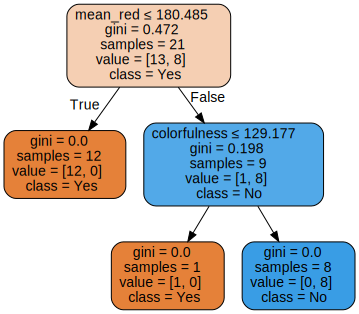

In [ ]:
from sklearn.tree import export_graphviz
dot_data = export_graphviz(classifier_decision_tree, out_file=None,feature_names=["mean_red", "mean_green", "mean_blue", "mean_alpha","std_dev_red","std_dev_green","std_dev_blue","std_dev_alpha","contrast", "energy", "correlation","entropy_value", "colorfulness"],class_names=["Yes", "No"],filled=True, rounded=True,special_characters=True)

# Convert the dot file to a PNG file
import graphviz
graph = graphviz.Source(dot_data)
graph

In this section, we will visualize a few test images along with their true and predicted labels to better understand the classification results.


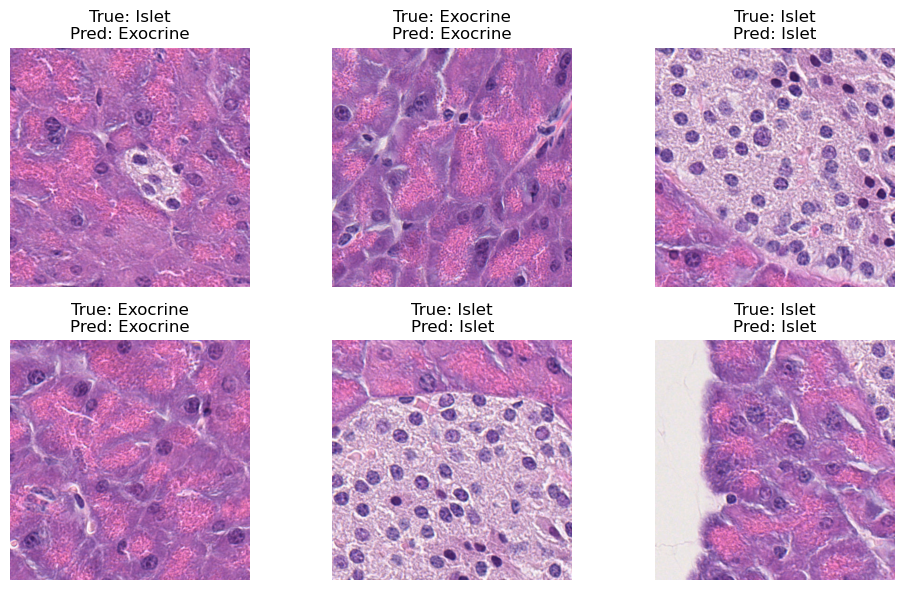

In [ ]:
# Visualize a few test images and their predictions
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test_combined[i, :512*512*4].reshape(512, 512,4).astype(np.uint8))
    true_label = "Islet" if y_test[i] == 1 else "Exocrine"
    pred_label = "Islet" if y_pred_decision_tree[i] == 1 else "Exocrine"
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()